# Virtual diffractometer axis

Demonstrate a diffractometer where one of the expected axes must be computed
from one or more additional diffractometer positioners.

One case might be where a rotational axis $a$ is operated by a tangent linear
translation $y$ at fixed distance $x$ from the center of rotation.  In this
simple sketch, the relationships are defined: {math}`\tan{a} = y / x`

![sketch](../_static/th_tth-virt-axis-sketch.png)

## Preparation

The virtual axis must be defined with the features common to the other
diffractometer axes (all based on `ophyd.PositionerBase`).

Since this is a virtual *real* axis and not a *pseudo*, the easiest way to
ensure these features are available is to create a subclass of
`ophyd.SoftPositioner` (based on `ophyd.PositionerBase`) and override the parts
which are custom to the virtual axis.  A virtual *pseudo* axis should subclass
from `hklpy2.Hklpy2PseudoAxis`.

The `ophyd.DerivedSignal` is not based on `ophyd.PositionerBase` and, as such,
is missing many features of the positioner interface.

**Parameters**

- $x$ : A constant specified when creating the diffractometer object.  Same
  engineering units as $y$.
- $y$ : The physical translation axis.  Specify the *name* of this diffractometer
  Component when creating the diffractometer object.  The virtual positioner
  class will access the named diffractometer Component.
- $a$ : The virtual rotation angle.  When $a$ is read, its position is computed
  from  $y$.  Any movement of $a$ is translated into a movement of $y$.

### Virtual positioner class

Custom class for the particular specifications of this virtual axis. Describes
the **Parameters** above in the `__init__()` constructor method and implements
their design in the class **Overrides** and **Additions** methods.

axis type | base class
--- | ---
*pseudo* | `hklpy2.Hklpy2PseudoAxis`
*real* | `ophyd.SoftPositioner`

**Overrides**

Custom methods that *replace* base class methods.

- `position` (`@property`) : Returns current position of $a$, computed from $y$.
- `_set_position()`: Moves $y$ when $a$ is moved.

  *FIXME*: **MIGHT NEED REFACTOR HERE.**
  - Not certain this is the right method to override or the right content in the method.
  - Pseudo does not move when $y$ is moved.

**Additions**

Custom methods for this class, not provided by the base class.

The virtual axis limits are computed from the translation axis limits using the
`forward()` method.

- `forward()`: Compute $a$ from $y$.
- `inverse()`: Compute $y$ from $a$.
- `_recompute_limits()`: Using `forward()`, compute limits of $a$ from $y$.


In [1]:
import math

from ophyd import Component
from ophyd import SoftPositioner


class VirtualRotationPositioner(SoftPositioner):
    """Compute rotation from translation axis."""

    def __init__(self, *, distance: float = 100, t_name: str = "dy", **kwargs):
        """."""
        self.distance = distance  # same units as translation
        super().__init__(**kwargs)

        self.translation = getattr(self.parent, t_name)
        if self.translation.connected:
            self._recompute_limits()

    def forward(self, translation: float) -> float:
        """Return rotation angle (degrees) from translation."""
        return math.atan2(translation, self.distance) * 180 / math.pi

    def inverse(self, rotation: float) -> float:
        """Return translation from rotation angle (degrees)."""
        return self.distance * math.tan(rotation * math.pi / 180)

    @property
    def position(self) -> float:
        """The current rotation angle, as computed from translation position."""
        try:
            translation = self.translation.position
        except AttributeError:
            translation = 0  # during initialization

        self._position = self.forward(translation)
        return self._position

    def _set_position(self, value, **kwargs):
        """
        Set the translation position from rotation angle.

        '._set_position()' is called during the .'move()' method.
        It appears this in in lieu of a position setter property.
        """
        try:
            # move the translation axis
            angle = self.inverse(value)
            self.translation._set_position(angle, **kwargs)
        except AttributeError:
            pass  # during initialization
        finally:
            super()._set_position(value, **kwargs)

    def _recompute_limits(self) -> None:
        """Compute rotation axis limits from translation."""
        try:
            self._limits = tuple(sorted(map(self.forward, self.translation.limits)))
        except AttributeError:
            pass  # during initialization

### Custom diffractometer class

Here, we pick the
[4-circle](https://blueskyproject.io/hklpy2/diffractometers.html#solver-hkl-soleil-geometry-e4cv)
`E4CV` geometry to demonstrate a diffractometer that uses this new
{class}`VirtualRotationPositioner` class.

- `tth` (as $a$): Override the existing `tth` Component with the
  `VirtualRotationPositioner`, supplying the additional kwargs.

- `dy` (as $y$): Add a `dy` Component as a `SoftPositioner`, supplying initial
  position and limits.

- `distance` (as $x$):  Pass this constant as a keyword argument when constructing
  the diffractometer object.

Note the `kind="hinted"` kwarg, which designates a Component to be included in a
live table or plot during a scan.

<details>
<summary>Why not use <tt>hklpy2.creator()</tt>?</summary>

We must write our own Python class. The `hklpy2.creator()` is not prepared
[yet](https://github.com/bluesky/hklpy2/issues/113) to create a diffractometer
with a custom class and keyword arguments such as this one.  

<details>
<summary>Maybe, in the future ...</summary>

```python
gonio = hklpy2.creator(
    name="gonio",
    solver="hkl_soleil",
    geometry="E4CV",
    reals = {
        omega: None,
        chi: None,
        phi: None,
        tth: {
            class: VirtualRotationPositioner,
            init_pos=0,
            t_name="dy",
            distance=1000,
            kind="hinted",
        },
        dy: {
            limits=(-10, 200),
            # all other kwargs use defaults
        }
    }
)
```

</details>

</details>
<br />

Using the factory function to create a base class, we define a custom class:

In [2]:
import hklpy2

MyBase = hklpy2.diffractometer_class_factory(
    solver="hkl_soleil",
    geometry="E4CV",
)


class MyGoniometer(MyBase):
    # Replace existing axis with virtual 2Theta.
    # Point it at the 'dy' axis (below).
    tth = Component(
        VirtualRotationPositioner,
        init_pos=0,
        t_name="dy",
        distance=1000,
        kind="hinted",
    )

    # Add the translation axis 'dy'.
    dy = Component(
        SoftPositioner,
        init_pos=0,
        limits=(-10, 200),
        kind="hinted",
    )

### Diffractometer object

- Move `dy` (physical axis), report `tth` and `l` at each step.
- Move `tth` (virtual axis), report `dy` and `l` at each step.
- Move `l` (pseudo axis), report `tth` and `dy` at each step.

In [3]:
gonio = MyGoniometer(name="gonio")
gonio.add_sample("vibranium", 2*3.14)
gonio.wh()

wavelength=1.0
pseudos: h=0, k=0, l=0
reals: omega=0, chi=0, phi=0, tth=0
positioners: dy=0


## Bluesky scans

Demonstrate the relationships between `dy`, `tth`, and `l` through bluesky scans.

- Scan `dy` (physical axis), report `tth` and `l` at each step.
- Scan `tth` (virtual axis), report `dy` and `l` at each step.
- Scan `l` (pseudo axis), report `tth` and `dy` at each step.

Start with a simple setup, but no detectors or data collection.  Just tables and plotting.

In [4]:
import bluesky
from bluesky import plans as bp
from bluesky.callbacks.best_effort import BestEffortCallback

bec = BestEffortCallback()
RE = bluesky.RunEngine()
RE.subscribe(bec)

0

### Scan *physical* axis `dy`



Transient Scan ID: 1     Time: 2025-07-14 10:57:43
Persistent Unique Scan ID: 'e2b64e15-d19a-41b3-ae15-231647f5c02a'
New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |   gonio_dy |  gonio_tth |    gonio_l |
+-----------+------------+------------+------------+------------+
|         1 | 10:57:43.3 |     -1.000 |     -0.057 |          0 |
|         2 | 10:57:43.5 |      0.100 |      0.006 |          0 |
|         3 | 10:57:43.7 |      1.200 |      0.069 |          0 |
|         4 | 10:57:43.8 |      2.300 |      0.132 |          0 |
|         5 | 10:57:44.0 |      3.400 |      0.195 |          0 |
|         6 | 10:57:44.1 |      4.500 |      0.258 |          0 |
|         7 | 10:57:44.3 |      5.600 |      0.321 |          0 |
|         8 | 10:57:44.4 |      6.700 |      0.384 |          0 |
|         9 | 10:57:44.5 |      7.800 |      0.447 |          0 |
|        10 | 10:57:44.7 |      8.900 |      0.510 |          0 |
|

/home/prjemian/.conda/envs/hklpy2/lib/python3.13/site-packages/bluesky/callbacks/fitting.py:171: RuntimeWarning: invalid value encountered in scalar divide
  results = [np.sum(input * grids[dir].astype(float), labels, index) / normalizer for dir in range(input.ndim)]





wavelength=1.0
pseudos: h=0, k=0, l=0
reals: omega=0, chi=0, phi=0, tth=0.5729
positioners: dy=10.0


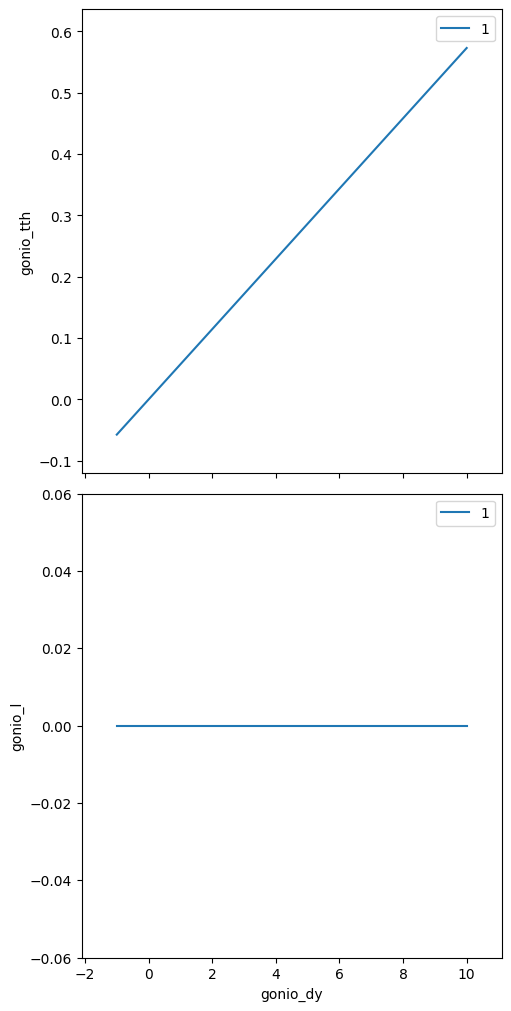

In [5]:
# FIXME: l does not move when dy is moved.  Needs a subscription?
RE(bp.scan([gonio.tth, gonio.l], gonio.dy, -1, 10, 11))
gonio.wh()

### Scan *virtual* axis `tth`



Transient Scan ID: 2     Time: 2025-07-14 10:57:45
Persistent Unique Scan ID: 'b5f7b3e8-b9ad-4d13-82fc-41c56948dbe0'
New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |  gonio_tth |   gonio_dy |    gonio_l |
+-----------+------------+------------+------------+------------+
|         1 | 10:57:45.4 |     -0.100 |     -1.745 |     -0.011 |
|         2 | 10:57:45.6 |     -0.040 |     -0.698 |     -0.004 |
|         3 | 10:57:45.8 |      0.020 |      0.349 |      0.002 |
|         4 | 10:57:45.9 |      0.080 |      1.396 |      0.009 |
|         5 | 10:57:46.1 |      0.140 |      2.443 |      0.015 |
|         6 | 10:57:46.2 |      0.200 |      3.491 |      0.022 |
|         7 | 10:57:46.4 |      0.260 |      4.538 |      0.028 |
|         8 | 10:57:46.5 |      0.320 |      5.585 |      0.035 |
|         9 | 10:57:46.7 |      0.380 |      6.632 |      0.042 |
|        10 | 10:57:46.8 |      0.440 |      7.680 |      0.048 |
|

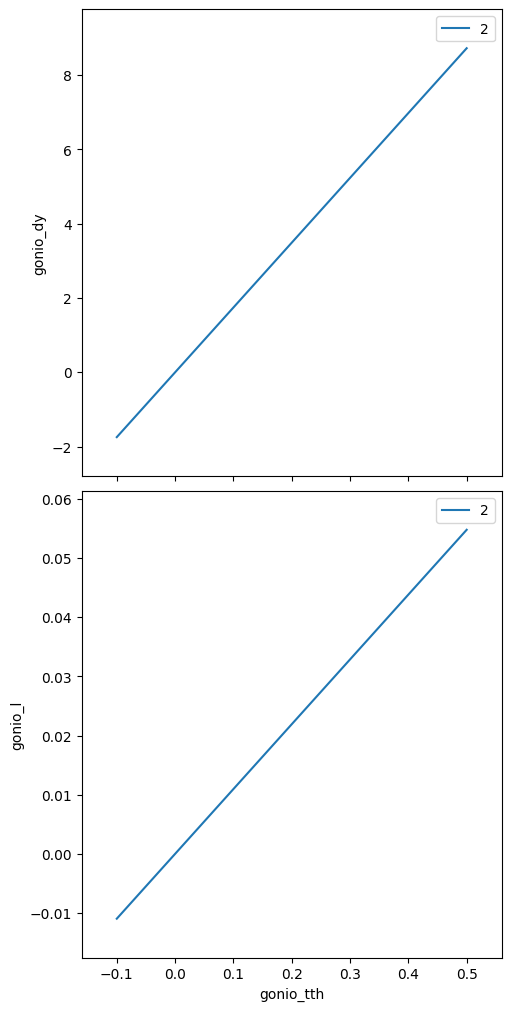

In [6]:
RE(bp.scan([gonio.l, gonio.dy], gonio.tth, -0.1, 0.5, 11))
gonio.wh(full=True)

### Scan *pseudo* axis `l`



Transient Scan ID: 3     Time: 2025-07-14 10:57:47
Persistent Unique Scan ID: '5c853af1-1077-4ab3-bccb-a0104fd1269e'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+
|   seq_num |       time |    gonio_l |  gonio_tth |   gonio_dy | gonio_omega |
+-----------+------------+------------+------------+------------+-------------+
|         1 | 10:57:47.6 |      0.010 |      0.091 |      1.593 |       0.046 |
|         2 | 10:57:47.9 |      0.014 |      0.128 |      2.230 |      -0.064 |
|         3 | 10:57:48.2 |      0.018 |      0.164 |      2.867 |      -0.082 |
|         4 | 10:57:48.5 |      0.022 |      0.201 |      3.503 |       0.100 |
|         5 | 10:57:48.9 |      0.026 |      0.237 |      4.140 |       0.119 |
|         6 | 10:57:49.2 |      0.030 |      0.274 |      4.777 |       0.137 |
|         7 | 10:57:49.5 |      0.034 |      0.310 |      5.414 |       0.155 |
|         8 | 10:57:49.8 |      0.038 |      0.347 |      6

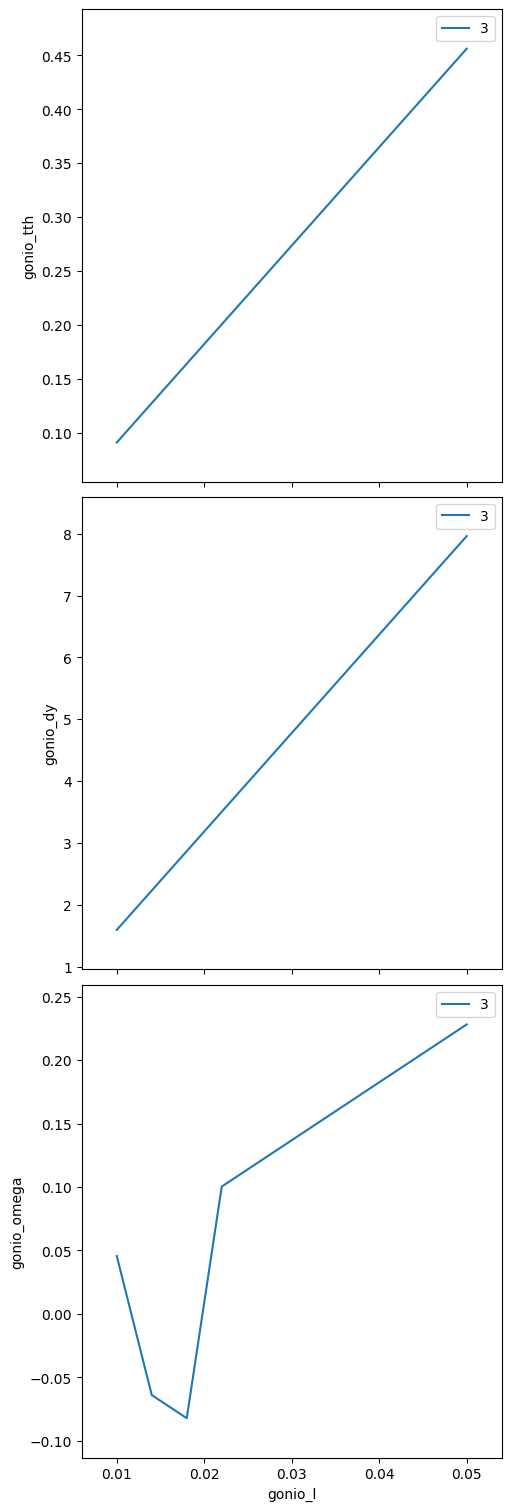

In [7]:
RE(bp.scan([gonio.omega, gonio.tth, gonio.dy], gonio.l, 0.01, 0.05, 11))
gonio.wh()